# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 

## Group Project: Alzheimer’s Disease and Cognitive Impairment Prediction


**Group 86**<br/>
**Group Member**: Yawen Gao, Weiyu Yao, Yue Li

<hr style="height:2pt">



In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

<hr style="height:2pt">

**Libraries:**

In [2]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

import math
from scipy.special import gamma

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image

import seaborn as sns
sns.set()

from IPython.display import display

# random forest:
from itertools import product
from collections import OrderedDict
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split


<div class='theme'> Data Cleaning & Preliminary EDA </div>



Alzheimer’s disease (AD) is a type of dementia that causes problems with memory, thinking and influence people to lead a normal life. AD is an irreversible process that typically begins after 60. Currently, there is no efficient treatment for Alzheimer’s. The impact of AD on individual, society and economy is profound. In the United States, more than 5 million people aged 65 and over suffer from the disease. AD is now the number 6 leading cause of death in the United States and it is the number 3 leading cause of death for older people just behind heart disease and cancer. The estimated national cost for AD was $236 billion in 2016. Given that AD is irreversible nature of AD, early detection can bring a lot benefits to the intervention of AD progression. The Alzheimer's Disease Neuroimaging Initiative (ADNI)
is a longitudinal multicenter study designed to develop imaging, genetic, clinical, and biochemical biomarkers in order to detect or track AD at early stage. Our goal is to build a prediction model for a Alzheimer’s or cognitive impairment related investigation using patient demographic information, medical records and related data in ADNI database.

<div class='exercise'><b>  Description of Raw Data </b></div>

Through four phases of ADNI study, participants were carried forward from previous phases for continued monitoring, while new enrollees were added with each phase to further investigate evolution of AD. Participants of the study are between 55 to 90 years old, who are from 57 sites in the US and Canada. After obtaining informed consent, participants would go through a series of initial tests and take repeated at intervals over subsequent years. Tests include clinical evaluation, neuropsychological tests, genetic testing, lumbar puncture, and MRI and PET scans.

Below are the summary of each data type.

**1. Clinical data**

In [3]:
# read in data
df = pd.read_csv('/Users/sophie/Desktop/group project/ADNIMERGE.csv')
display(df.columns)

Index(['RID', 'PTID', 'VISCODE', 'SITE', 'COLPROT', 'ORIGPROT', 'EXAMDATE',
       'DX_bl', 'AGE', 'PTGENDER', 'PTEDUCAT', 'PTETHCAT', 'PTRACCAT',
       'PTMARRY', 'APOE4', 'FDG', 'PIB', 'AV45', 'CDRSB', 'ADAS11', 'ADAS13',
       'MMSE', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting',
       'RAVLT_perc_forgetting', 'FAQ', 'MOCA', 'EcogPtMem', 'EcogPtLang',
       'EcogPtVisspat', 'EcogPtPlan', 'EcogPtOrgan', 'EcogPtDivatt',
       'EcogPtTotal', 'EcogSPMem', 'EcogSPLang', 'EcogSPVisspat', 'EcogSPPlan',
       'EcogSPOrgan', 'EcogSPDivatt', 'EcogSPTotal', 'FLDSTRENG', 'FSVERSION',
       'Ventricles', 'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform',
       'MidTemp', 'ICV', 'DX', 'EXAMDATE_bl', 'CDRSB_bl', 'ADAS11_bl',
       'ADAS13_bl', 'MMSE_bl', 'RAVLT_immediate_bl', 'RAVLT_learning_bl',
       'RAVLT_forgetting_bl', 'RAVLT_perc_forgetting_bl', 'FAQ_bl',
       'FLDSTRENG_bl', 'FSVERSION_bl', 'Ventricles_bl', 'Hippocampus_bl',
       'WholeBrain_bl', 'Entorhinal_bl

DROP: Observations:

- Dependent variable 'DX' missing observations.
- All observation with 'VISCODE' other than 'bl', only consider baseline observations for each patients. ('VISCODE' is then deleted because useless.)

In [4]:
#keep only the baseline value for all the variables. (also deleting "VISCODE")
df2 = {}
var = list(df.columns.drop('VISCODE'))
for i in var:
    df2[i] = df[i][df['VISCODE'] == 'bl']
df2 = pd.DataFrame(df2)
print(len(df)-len(df2), 'observation deleted. And variable "VISCODE" is deleted.')

#drop the observation if 'DX' is missing
df3 = {}
var = list(df2.columns.drop('DX'))
for i in var:
    df3[i] = df2[i][df2['DX'].isnull() == False]
df2['DX'].fillna(-1, inplace = True)
df2_DX = list(df2['DX'])
while -1 in df2_DX:
    df2_DX.remove(-1)
df3['DX'] = df2_DX
df3 = pd.DataFrame(df3)
print(len(df2)-len(df3), 'observation deleted.')
print(len(df3), 'observations left.')

11233 observation deleted. And variable "VISCODE" is deleted.
15 observation deleted.
1769 observations left.


Variables:
DROP:
- 'PTID': The same with 'RID' but in different forms.
- 'SITE': Location of measurement, useless.
- 'COLPROT', 'ORIGPROT': The protol under which the data is collect, we assume the data under different are comparable and thus can be run into the same model, so classification of this variables is unecessary.
- 'EXAMDATE': We are not interested in longitudinal information.
- All the variables with 'bl' ending: We are not interested in longitudinal data, and baseline value for each variable are included in the same variable without 'bl' ending. These variables include:  'DX_bl', 'EXAMDATE_bl', 'CDRSB_bl', 'ADAS11_bl', 'ADAS13_bl', 'MMSE_bl', 'RAVLT_immediate_bl', 'RAVLT_learning_bl', 'RAVLT_forgetting_bl', 'RAVLT_perc_forgetting_bl', 'FAQ_bl','FLDSTRENG_bl', 'FSVERSION_bl', 'Ventricles_bl', 'Hippocampus_bl', 'WholeBrain_bl', 'Entorhinal_bl', 'Fusiform_bl', 'MidTemp_bl', 'ICV_bl', 'MOCA_bl', 'EcogPtMem_bl', 'EcogPtLang_bl', 'EcogPtVisspat_bl', 'EcogPtPlan_bl', 'EcogPtOrgan_bl', 'EcogPtDivatt_bl', 'EcogPtTotal_bl', 'EcogSPMem_bl', 'EcogSPLang_bl', 'EcogSPVisspat_bl', 'EcogSPPlan_bl', 'EcogSPOrgan_bl', 'EcogSPDivatt_bl', 'EcogSPTotal_bl', 'FDG_bl', 'PIB_bl', 'AV45_bl', 'Years_bl', 'Month_bl'.
- 'RID': RID becomes uselss because now the data is unique for each patient, so ID for patient is not needed.
- 'Month', 'M', 'update_stamp': We are not interested in longitudinal information.
- 'FLDSTRENG', 'FSVERSION': Paramenters for examinition is not needed since they are not relate to patients' health status.
- All Ecog test results by the patient: In many literature, patients' self-report test result are often not reliable and are often considered as nonsense, which contain very little information for the prediction model. These include 'EcogPtMem', 'EcogPtLang', 'EcogPtVisspat', 'EcogPtPlan', 'EcogPtOrgan', 'EcogPtDivatt', 'EcogPtTotal'.

In [5]:
#drop variables that are selected based on the criteria above
bad = ['PTID','SITE','COLPROT','ORIGPROT', 'EXAMDATE', 'DX_bl', 'EXAMDATE_bl', 
       'CDRSB_bl', 'ADAS11_bl', 'ADAS13_bl', 'MMSE_bl', 'RAVLT_immediate_bl', 'RAVLT_learning_bl', 'RAVLT_forgetting_bl', 
       'RAVLT_perc_forgetting_bl', 'FAQ_bl','FLDSTRENG_bl', 'FSVERSION_bl', 'Ventricles_bl', 'Hippocampus_bl', 
       'WholeBrain_bl', 'Entorhinal_bl', 'Fusiform_bl', 'MidTemp_bl', 'ICV_bl', 'MOCA_bl', 'EcogPtMem_bl', 'EcogPtLang_bl', 
       'EcogPtVisspat_bl', 'EcogPtPlan_bl', 'EcogPtOrgan_bl', 'EcogPtDivatt_bl', 'EcogPtTotal_bl', 'EcogSPMem_bl', 'EcogSPLang_bl', 
       'EcogSPVisspat_bl', 'EcogSPPlan_bl', 'EcogSPOrgan_bl', 'EcogSPDivatt_bl', 'EcogSPTotal_bl', 'FDG_bl', 'PIB_bl', 'AV45_bl', 
       'Years_bl', 'Month_bl', 'RID', 'Month', 'M', 'update_stamp', 'FLDSTRENG', 'FSVERSION','EcogPtMem', 'EcogPtLang', 'EcogPtVisspat', \
       'EcogPtPlan', 'EcogPtOrgan', 'EcogPtDivatt', 'EcogPtTotal']
df4 = df3.drop(bad, axis = 1)
print(len(list(df3.columns))-len(list(df4.columns)), 'variables are deleted.')
print('Remaining variables are:', list(df4.columns))

58 variables are deleted.
Remaining variables are: ['AGE', 'PTGENDER', 'PTEDUCAT', 'PTETHCAT', 'PTRACCAT', 'PTMARRY', 'APOE4', 'FDG', 'PIB', 'AV45', 'CDRSB', 'ADAS11', 'ADAS13', 'MMSE', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting', 'RAVLT_perc_forgetting', 'FAQ', 'MOCA', 'EcogSPMem', 'EcogSPLang', 'EcogSPVisspat', 'EcogSPPlan', 'EcogSPOrgan', 'EcogSPDivatt', 'EcogSPTotal', 'Ventricles', 'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp', 'ICV', 'DX']


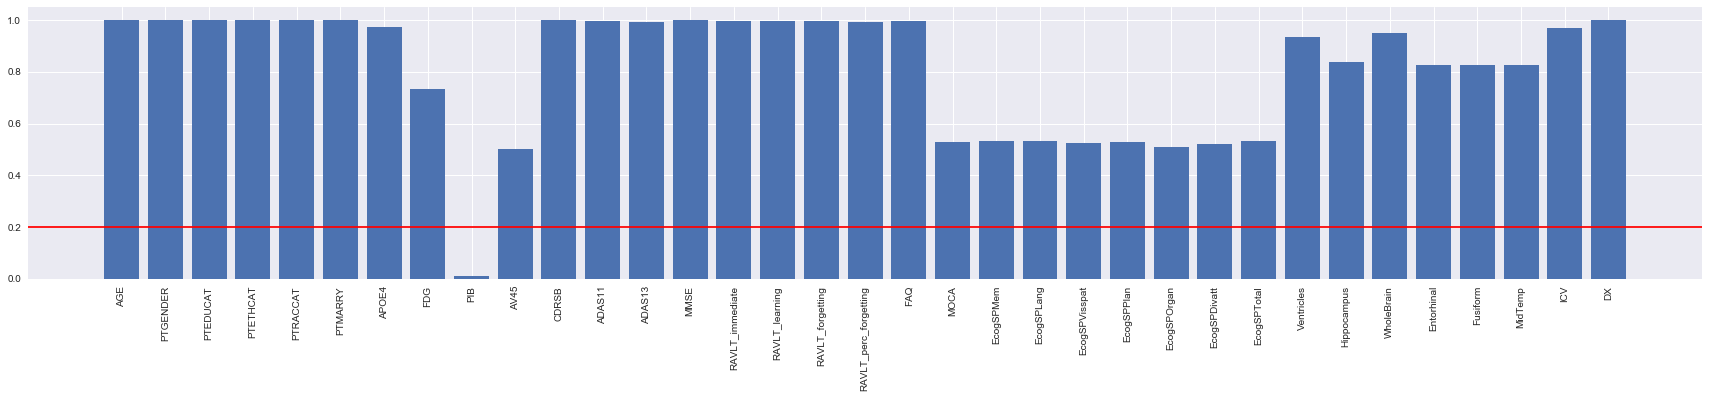

1 variables are deleted.
Deleted variables are: ['PIB']


In [6]:
#cout the NaNs in each variables, drop variables that observations are not greater than 20%.
perc = []
bad2 = []
for i in list(df4.columns):
    perc_temp = 1-df4[i].isnull().sum()/len(df4)
    perc.append(perc_temp)
    if perc_temp < 0.2:
        bad2.append(i)
plt.figure(figsize=(30,5))
plt.bar(list(df4.columns), perc)
plt.xticks(list(df4.columns), rotation=90)
plt.axhline(0.2, c = 'r')
plt.show()
df5 = df4.drop(bad2, axis = 1)
print(len(list(df4.columns))-len(list(df5.columns)), 'variables are deleted.')
print('Deleted variables are:', bad2)

De-labeling variables, turn categorical varibles into 0,1,2,3, and turn all 'Unknown' value into NaNs.

In [7]:
#Turn all values of categorical variables into categories named in 0, 1, 2, 3...while keeping NaN and turining all 'Unknown's to NaN

cat = [] #list of names of categorical variables
catdict_raw = {} #dictionary with names of categorical variables as keys, and all categories as values, including nan & 'Unknown'
catdict = {} #dictionary with names of categorical variables as keys, and non-nan categories as values (excluding nan & 'Unknown')

#convert 'APOE4' to string, because it is categorical but will be regarded as continuous later.
df6 = {}
df6['APOE4'] = [-1]*len(df5['APOE4'])
for i in range(len(df5['APOE4'])):
    if list(df5['APOE4'])[i] != np.nan:
        df6['APOE4'][i] = str(list(df5['APOE4'])[i])

var = list(df5.columns.drop('APOE4'))
for i in var:
    df6[i] = list(df5[i])
df6 = pd.DataFrame(df6)
df6['APOE4'].replace(-1, np.nan, inplace = True)

for v in df6.columns:
    if df6[v].dtypes == 'O':
        cat.append(v)
        catdict_raw[v] = list(set(df6[v]))
        df6[v].fillna('Unknown', inplace = True) #replace all NaN first into 'Unknown'
        catdict[v] = list(set(df6[v]))
        catdict['APOE4'] = [0,1,2]
        if 'Unknown' in catdict[v]:
            catdict[v].remove('Unknown') #'Unknown' should not participate in categorizing
        for i in range(len(catdict[v])):
            df6[v].replace(catdict[v][i], i, inplace = True) #Turn all values of categorical variables into categories named in 0, 1, 2, 3...
        df6[v] = pd.to_numeric(df6[v], errors = 'coerce') #convert all 'Unknown's then to NaN
contin = list(df6.columns.drop(cat))
print('Categorical variables are:', cat, '\n')
print('Continuous variables are', contin, '\n')
print('The dictionary for values of categorical variable corresponding to their original names: \n', catdict)

Categorical variables are: ['APOE4', 'PTGENDER', 'PTETHCAT', 'PTRACCAT', 'PTMARRY', 'DX'] 

Continuous variables are ['AGE', 'PTEDUCAT', 'FDG', 'AV45', 'CDRSB', 'ADAS11', 'ADAS13', 'MMSE', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting', 'RAVLT_perc_forgetting', 'FAQ', 'MOCA', 'EcogSPMem', 'EcogSPLang', 'EcogSPVisspat', 'EcogSPPlan', 'EcogSPOrgan', 'EcogSPDivatt', 'EcogSPTotal', 'Ventricles', 'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp', 'ICV'] 

The dictionary for values of categorical variable corresponding to their original names: 
 {'APOE4': [0, 1, 2], 'PTGENDER': ['Male', 'Female'], 'PTETHCAT': ['Hisp/Latino', 'Not Hisp/Latino'], 'PTRACCAT': ['More than one', 'Asian', 'Am Indian/Alaskan', 'White', 'Black', 'Hawaiian/Other PI'], 'PTMARRY': ['Never married', 'Divorced', 'Married', 'Widowed'], 'DX': ['CN', 'MCI', 'Dementia']}


<div class='exercise'> <b> 2. Preliminary EDA </b> </div>

We want to draw the correlation matrix, which needs the correlation value for each two pair of variables. In this case, it is better if we not treat NaN (like assigning NaN with random values or mean values) because the loss of data is small when doing correlation analysis, the probability of two variables either has a NaN is small, so we just delete any pair that either variable has a NaN. So, in correlation analysis, it is better to keep all the NaNs. 

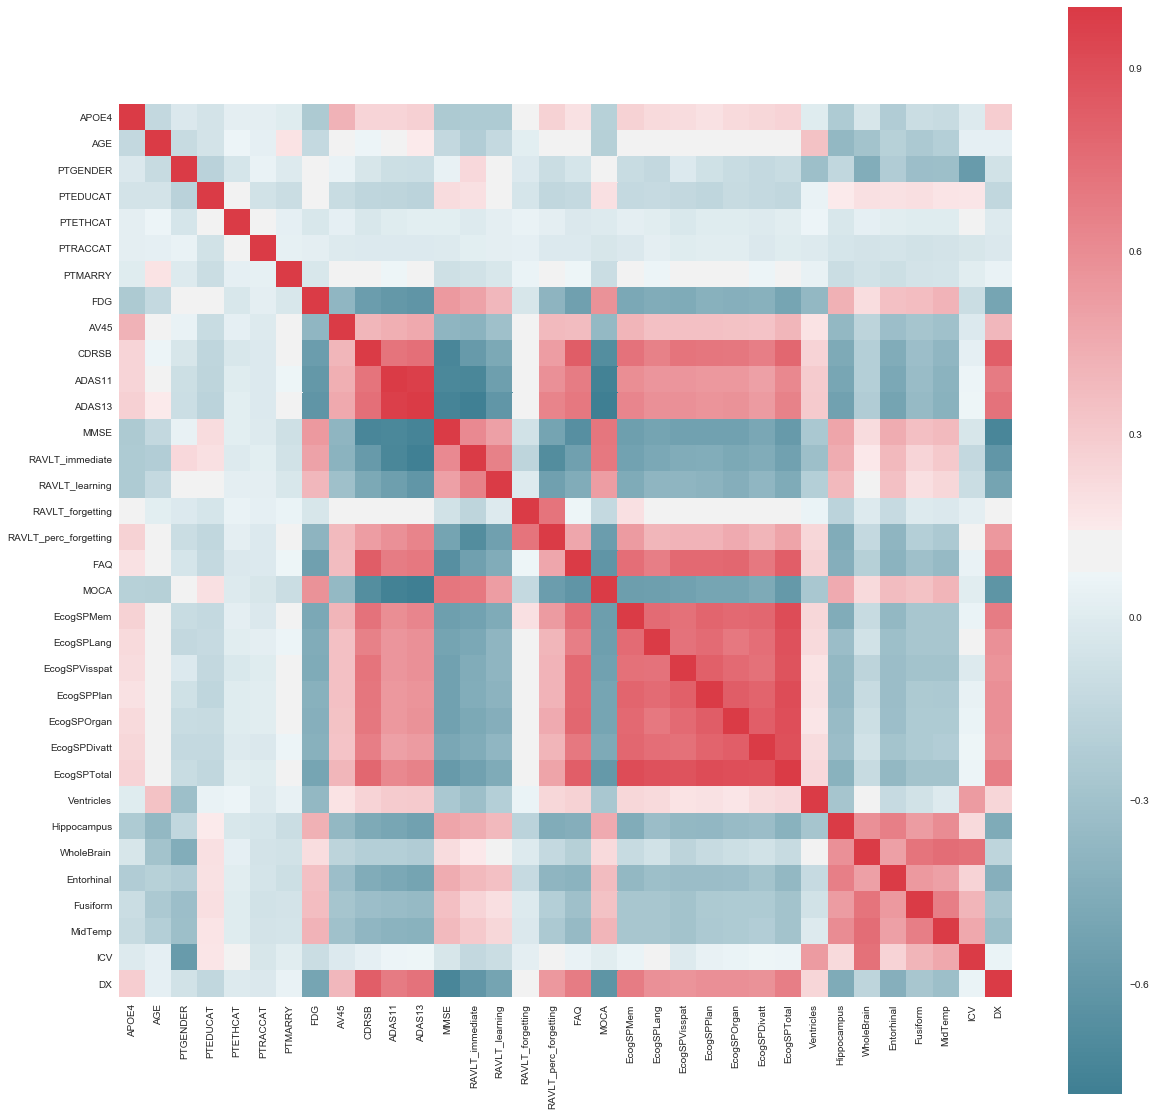

In [8]:
import seaborn as sns
f, ax = plt.subplots(figsize=(20,20))
corr = df6.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

<div class='exercise'> <b> 3. Data Cleaning (Step 2) for Regression </b> </div>

(((((When we take a closer look at the variables, we found that a lot of them are useless and redundant. The structure of the dataset is like this, for different row, it may contains different measurement for the same individual, for columns, it also contains baseline value for each individual. Since we have the baseline value in a particular row of that individual, we do not need baseline value as independent variables to be included into our models. So we delete columns appearing again 'bl' attaching to the end. And also for the last four time variables they are exactly the same, so we just keep years and drop the others. And also, 'Examdate' has exactly the same interval with 'years', because we have the age of the patient at basline, we can delete 'Examdate' as well. 'update_stamp' seems useless. Also, 'FLDSTRENG', 'FSVERSION' are the magnitue of the magnetic field and the version of the mearsurement, which are not useful for the mdoel because they are not the result from patients.
Another important thing we need to mention is that the data also contains many diagnose-related data, like the test result of ADAS11, ADAS13, RAVLT and MMSE. All these test will be highly correlated with the outcome, and also are not reasonable to be included in the model because if we already know the test result we lose the meaning of prediction. So we must delete these variables to make our final varibles reasonable for predictin models. 


In [9]:
df6.columns

Index(['APOE4', 'AGE', 'PTGENDER', 'PTEDUCAT', 'PTETHCAT', 'PTRACCAT',
       'PTMARRY', 'FDG', 'AV45', 'CDRSB', 'ADAS11', 'ADAS13', 'MMSE',
       'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting',
       'RAVLT_perc_forgetting', 'FAQ', 'MOCA', 'EcogSPMem', 'EcogSPLang',
       'EcogSPVisspat', 'EcogSPPlan', 'EcogSPOrgan', 'EcogSPDivatt',
       'EcogSPTotal', 'Ventricles', 'Hippocampus', 'WholeBrain', 'Entorhinal',
       'Fusiform', 'MidTemp', 'ICV', 'DX'],
      dtype='object')

However, when doing regression models, it is necessay to get rid of all the NaNs. So in this section we will carry on data cleaning for all the original NaNs and 'Unknown' values. 

In [10]:
df3.columns

Index(['RID', 'PTID', 'SITE', 'COLPROT', 'ORIGPROT', 'EXAMDATE', 'DX_bl',
       'AGE', 'PTGENDER', 'PTEDUCAT', 'PTETHCAT', 'PTRACCAT', 'PTMARRY',
       'APOE4', 'FDG', 'PIB', 'AV45', 'CDRSB', 'ADAS11', 'ADAS13', 'MMSE',
       'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting',
       'RAVLT_perc_forgetting', 'FAQ', 'MOCA', 'EcogPtMem', 'EcogPtLang',
       'EcogPtVisspat', 'EcogPtPlan', 'EcogPtOrgan', 'EcogPtDivatt',
       'EcogPtTotal', 'EcogSPMem', 'EcogSPLang', 'EcogSPVisspat', 'EcogSPPlan',
       'EcogSPOrgan', 'EcogSPDivatt', 'EcogSPTotal', 'FLDSTRENG', 'FSVERSION',
       'Ventricles', 'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform',
       'MidTemp', 'ICV', 'EXAMDATE_bl', 'CDRSB_bl', 'ADAS11_bl', 'ADAS13_bl',
       'MMSE_bl', 'RAVLT_immediate_bl', 'RAVLT_learning_bl',
       'RAVLT_forgetting_bl', 'RAVLT_perc_forgetting_bl', 'FAQ_bl',
       'FLDSTRENG_bl', 'FSVERSION_bl', 'Ventricles_bl', 'Hippocampus_bl',
       'WholeBrain_bl', 'Entorhinal_bl', 'Fusiform_bl',

In [11]:
# df5.isnull().values.any()
set(df5['DX'].dropna())
df6.isnull().values.sum()

9614

In [12]:
df6.groupby('DX')['AGE', 'PTEDUCAT', 'ICV',\
              'FDG','MMSE','RAVLT_immediate','RAVLT_learning','MOCA', 
              'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp',
              'AV45', 'CDRSB', 'ADAS11', 'ADAS13',   'RAVLT_forgetting', 'RAVLT_perc_forgetting', 'FAQ', \
              'EcogSPMem', 'EcogSPLang', 'EcogSPVisspat', 'EcogSPPlan', 'EcogSPOrgan', 'EcogSPDivatt', \
              'EcogSPTotal', 'Ventricles'].mean()

,AGE,PTEDUCAT,ICV,FDG,MMSE,RAVLT_immediate,RAVLT_learning,MOCA,Hippocampus,WholeBrain,...,RAVLT_perc_forgetting,FAQ,EcogSPMem,EcogSPLang,EcogSPVisspat,EcogSPPlan,EcogSPOrgan,EcogSPDivatt,EcogSPTotal,Ventricles
DX,,,,,,,,,,,,,,,,,,,,,
0,74.066062,16.392015,1.511499e+06,1.312089,29.074410,44.755920,5.910747,25.769716,7396.386076,1.033369e+06,...,35.114392,0.257713,1.376205,1.154848,1.091822,1.136551,1.197357,1.297771,1.209682,33748.203219
1,73.025029,15.907429,1.542031e+06,1.246289,27.598857,34.272000,4.085714,23.398734,6778.315217,1.030240e+06,...,60.540296,3.184845,2.165951,1.645632,1.419510,1.553602,1.636222,1.894935,1.727994,40552.134132
2,74.979883,15.183673,1.535440e+06,1.073014,23.224490,22.873529,1.852941,17.212329,5761.887273,9.769814e+05,...,89.032310,13.187135,3.247379,2.469959,2.381082,2.608844,2.806897,2.929224,2.731957,49816.827044


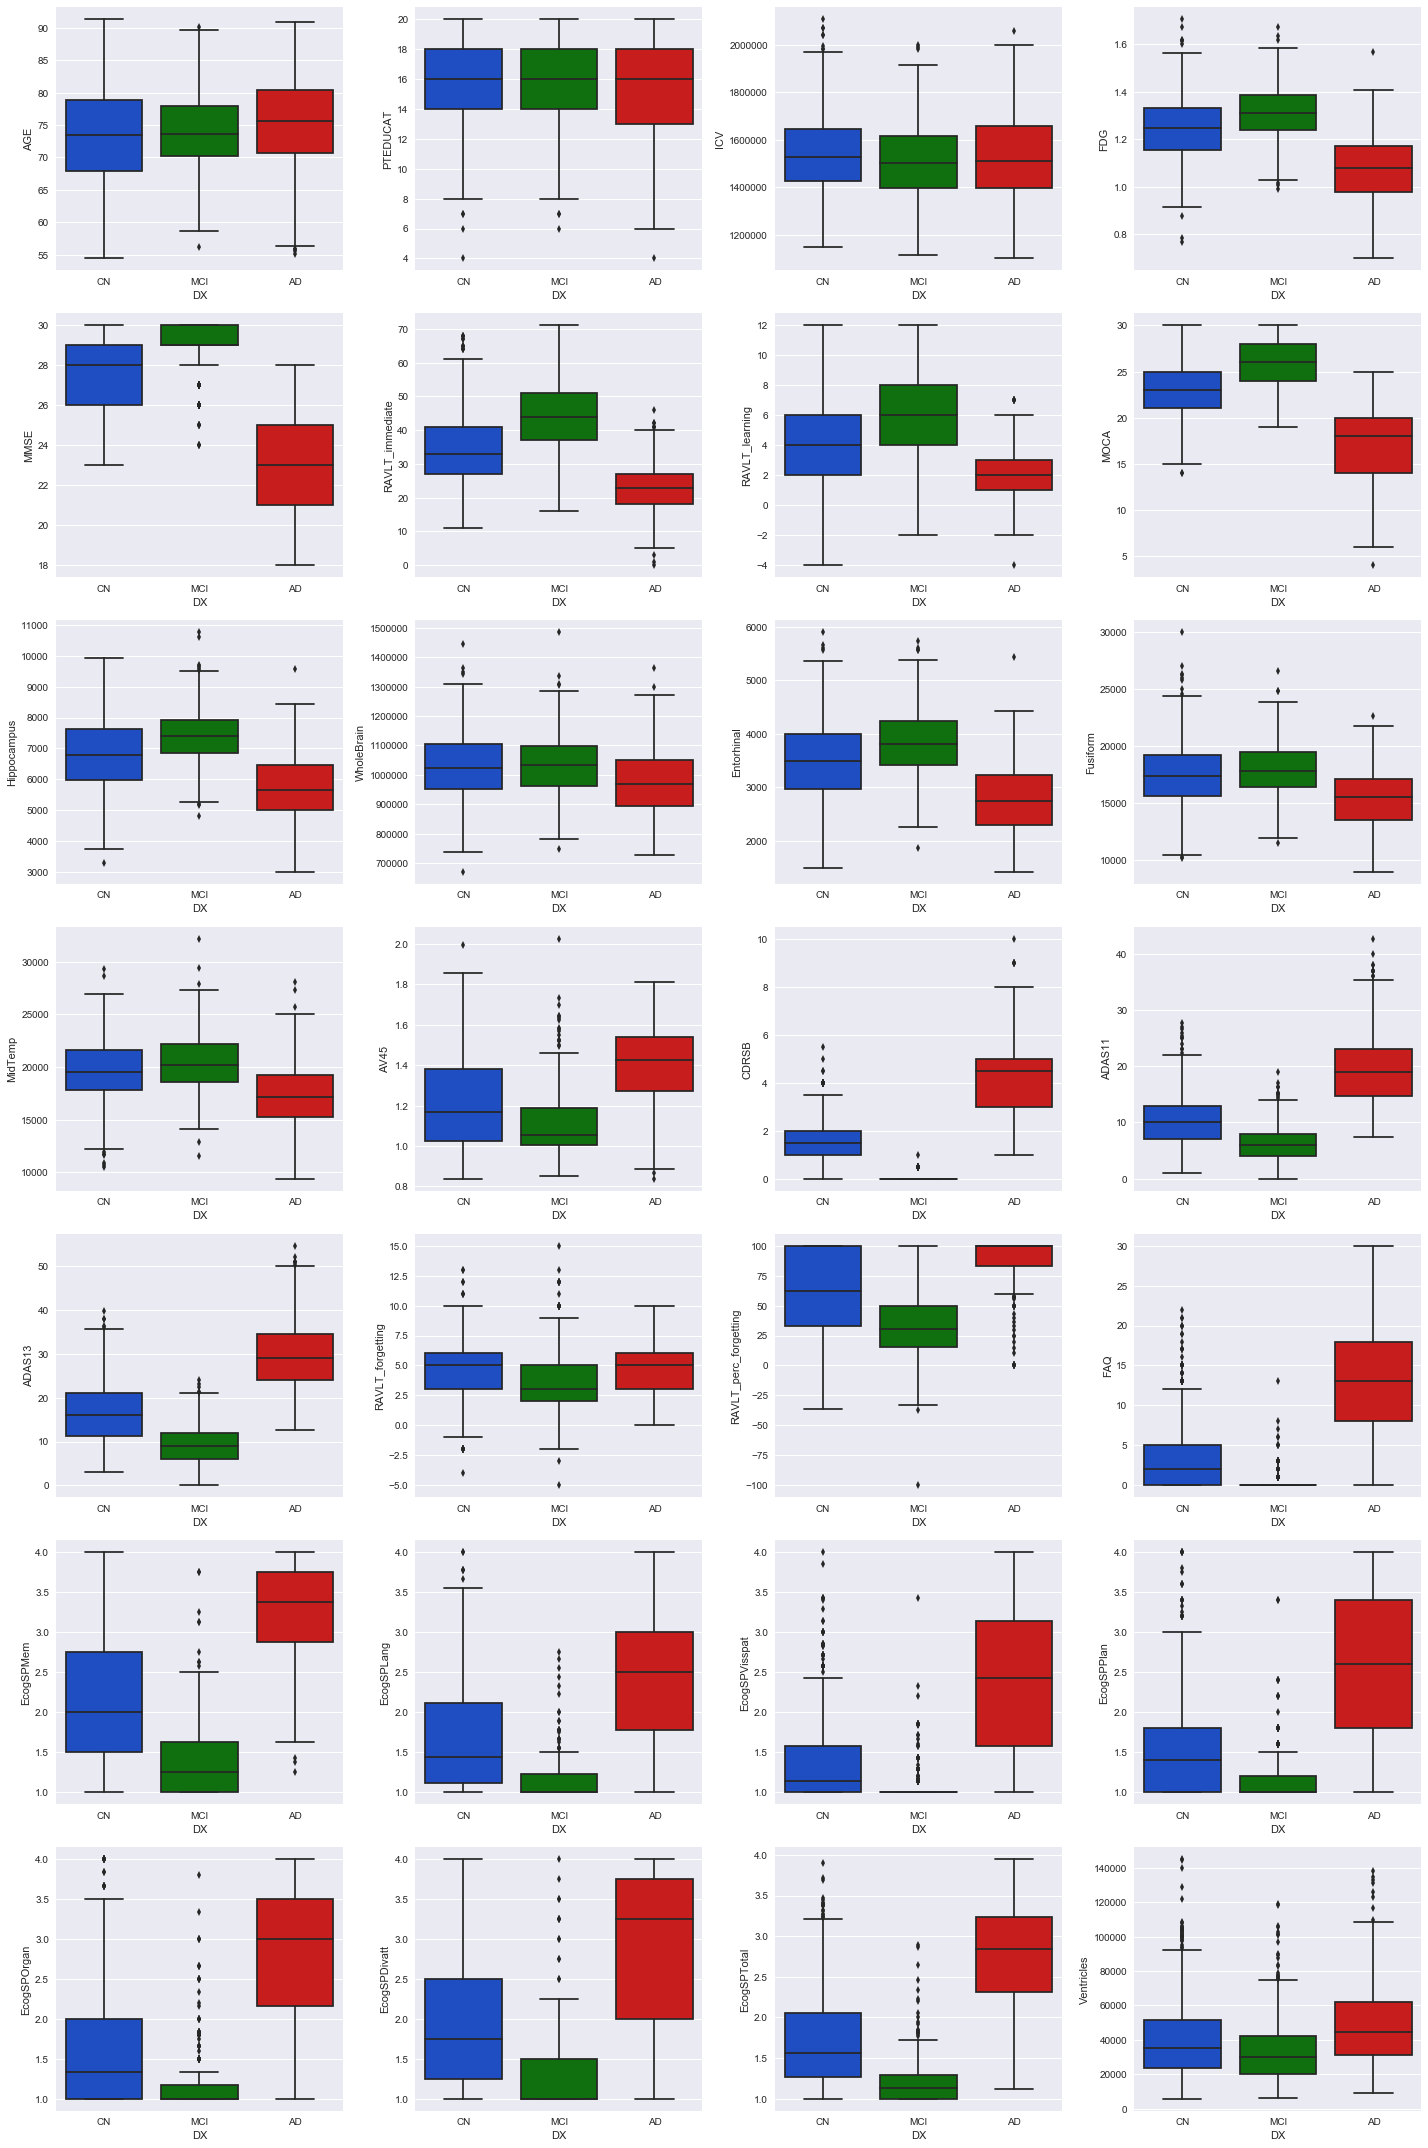

In [42]:
continuous = ['AGE', 'PTEDUCAT', 'ICV',\
              'FDG','MMSE','RAVLT_immediate','RAVLT_learning','MOCA', 
              'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp',
              'AV45', 'CDRSB', 'ADAS11', 'ADAS13',   'RAVLT_forgetting', 'RAVLT_perc_forgetting', 'FAQ', \
              'EcogSPMem', 'EcogSPLang', 'EcogSPVisspat', 'EcogSPPlan', 'EcogSPOrgan', 'EcogSPDivatt', \
              'EcogSPTotal', 'Ventricles'] 

fig, ax = plt.subplots(7,4,figsize = (20,30))
ax = ax.ravel()

for i in range(len(continuous)):
    sns.boxplot(x=df6['DX'], y=df6[continuous[i]],palette = ['#0343df', 'g', '#e50000'], ax=ax[i])
    fig.tight_layout()
    ax[i].set_xticklabels(['CN', 'MCI','AD'])

In [13]:
set(df6['DX'])
df6.dtypes

APOE4                    float64
AGE                      float64
PTGENDER                   int64
PTEDUCAT                   int64
PTETHCAT                 float64
PTRACCAT                 float64
PTMARRY                  float64
FDG                      float64
AV45                     float64
CDRSB                    float64
ADAS11                   float64
ADAS13                   float64
MMSE                     float64
RAVLT_immediate          float64
RAVLT_learning           float64
RAVLT_forgetting         float64
RAVLT_perc_forgetting    float64
FAQ                      float64
MOCA                     float64
EcogSPMem                float64
EcogSPLang               float64
EcogSPVisspat            float64
EcogSPPlan               float64
EcogSPOrgan              float64
EcogSPDivatt             float64
EcogSPTotal              float64
Ventricles               float64
Hippocampus              float64
WholeBrain               float64
Entorhinal               float64
Fusiform  

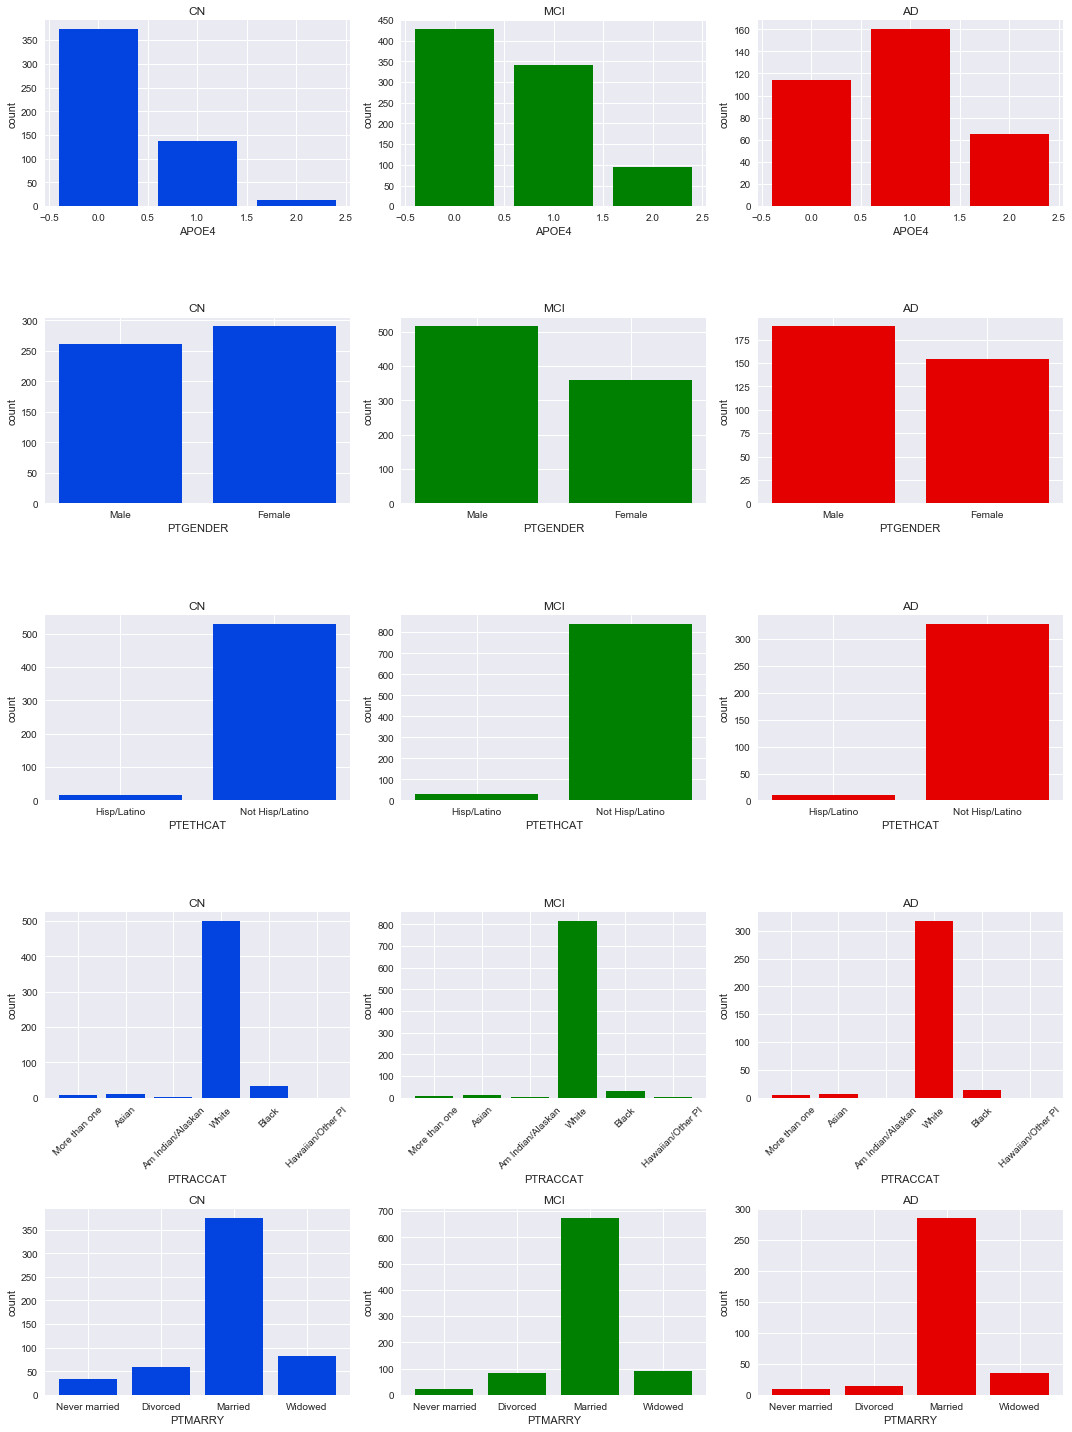

In [14]:
covariates = ['APOE4', 'PTGENDER', 'PTETHCAT', 'PTRACCAT', 'PTMARRY'] 
catdict['DX'] = ['CN', 'MCI', 'AD']
color = ['#0343df', 'g', '#e50000']
fig, ax = plt.subplots(len(covariates), 3, figsize=(15,20))
ax = ax.ravel()
a = 0
df_temp = df6.copy()
for i in covariates:
    for dx in list(set(df_temp['DX'])):
        count = []
        for cat in catdict[i]:
            count.append(sum(df_temp[i][df_temp['DX'] == dx] == catdict[i].index(cat)))
        ax[a].bar(catdict[i], count, alpha=1, color = color[int(dx)])
        ax[a].set_xlabel(i)
        ax[a].set_ylabel('count')
        ax[a].set_title(catdict['DX'][int(dx)])
        if i == 'PTRACCAT':
            ax[a].set_xticklabels(catdict[i], rotation=45)
        fig.tight_layout()
        a = a + 1

In [18]:
## IMPUTE MISSING DATA
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, IterativeImputer, BiScaler
#X=df5.drop(['DX'], axis=1)
#Y=df5['DX']
# Model each feature with missing values as a function of other features, and
# use that estimate for imputation.
X=df6.drop(['DX'], axis=1)
Y=df6['DX']
columns = X.columns

X_filled_ii = IterativeImputer().fit_transform(X)
X_filled_ii = pd.DataFrame(X_filled_ii)
X_filled_ii.columns = X.columns
#X_filled_ii

In [20]:
# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(X_filled_ii, Y, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1415, 33) (1415,)
(354, 33) (354,)


In [23]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import make_pipeline
ovr=LogisticRegressionCV(multi_class = 'ovr', cv=5)
ovr_model=LogisticRegressionCV(multi_class = 'ovr', cv=5).fit(X_train,y_train)
polynomial_logreg_estimator = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    LogisticRegressionCV(multi_class="ovr",cv=5))
poly_model = polynomial_logreg_estimator.fit(X_train,y_train)
np.mean(cross_val_score(ovr_model, X_train, y_train, cv=5))

0.5766787099561508

In [24]:
y_pred_test = ovr_model.predict(X_test)
accuracy_score(y_test, y_pred_test)

0.5790960451977402

In [43]:
#impute missing data with mean or median
cat = ['PTGENDER', 'PTEDUCAT', 'PTETHCAT', 'PTRACCAT', 'PTMARRY', 'APOE4']
contin = ['AGE', 'FDG', 'CDRSB', 'MMSE', 'FAQ',
       'Ventricles', 'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform',
       'MidTemp', 'ICV']
from statistics import mode
df6 = df5.copy()
for var in contin:
    median = np.nanmedian(df6[var])
    df6[var].fillna(median, inplace = True)

for var in cat:
    df6[var].fillna(10000000, inplace = True)
    df6[var] = df6[var].astype(int)
    mode = np.argmax(np.bincount(df6[var]))
    df6[var].replace(10000000, mode, inplace = True)


ValueError: invalid literal for int() with base 10: 'Male'

In [351]:
#impute former missing value with linear regression model or multi-classification model (with logistic regression) from df6
df7 = df5.copy()
for var in contin:
    if df5.isnull().sum()[var] !=0:
        df_temp = df6.drop(['RID', 'DX'], axis = 1)
        X_train = df_temp.drop(var, axis = 1)[df5[var].isnull() == False]
        y_train = df_temp[var][df5[var].isnull() == False]
        X_pred = df_temp.drop(var, axis = 1)[df5[var].isnull()]
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_pred)
        df7[var][df5[var].isnull()] = y_pred
        
for var in cat:
    df6[var] = df6[var].astype(int)
for var in cat:
    if df5.isnull().sum()[var] !=0:
        df_temp = df6.drop(['RID', 'DX'], axis = 1)
        X_train = df_temp.drop(var, axis = 1)[df5[var].isnull() == False]
        y_train = df_temp[var][df5[var].isnull() == False]
        X_pred = df_temp.drop(var, axis = 1)[df5[var].isnull()]
        model = LogisticRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_pred)
        df7[var][df5[var].isnull()] = y_pred

/Users/yaoweiyu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Users/yaoweiyu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [352]:
X_train.columns

Index(['AGE', 'PTGENDER', 'PTEDUCAT', 'PTETHCAT', 'PTRACCAT', 'PTMARRY', 'FDG',
       'CDRSB', 'MMSE', 'FAQ', 'Ventricles', 'Hippocampus', 'WholeBrain',
       'Entorhinal', 'Fusiform', 'MidTemp', 'ICV'],
      dtype='object')

In [30]:
### baseline RF model

random_forest = RandomForestClassifier(n_estimators=45, max_depth=18)
random_forest_model = random_forest.fit(X_train, y_train)


In [354]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import make_pipeline
ovr=LogisticRegressionCV(multi_class = 'ovr', cv=5)
ovr_model=LogisticRegressionCV(multi_class = 'ovr', cv=5).fit(X_train,y_train)
polynomial_logreg_estimator = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    LogisticRegressionCV(multi_class="ovr",cv=5))
poly_model = polynomial_logreg_estimator.fit(X_train,y_train)


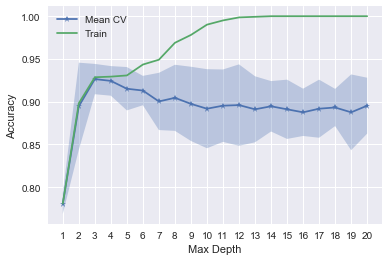

In [25]:
#decision tree
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
# find the best depth
depths = list(range(1, 21))
train_scores = []
cvmeans = []
cvstds = []
cv_scores = []
for depth in depths:
    dtree = DecisionTreeClassifier(max_depth=depth)
    # Perform 5-fold cross validation and store results
    train_scores.append(dtree.fit(X_train, y_train).score(X_train, y_train))
    scores = cross_val_score(estimator=dtree, X=X_train, y=y_train, cv=5)
    cvmeans.append(scores.mean())
    cvstds.append(scores.std())

cvmeans = np.array(cvmeans)
cvstds = np.array(cvstds)
# plot means and shade the 2 SD interval
plt.plot(depths, cvmeans, '*-', label="Mean CV")
plt.fill_between(depths, cvmeans - 2*cvstds, cvmeans + 2*cvstds, alpha=0.3)
ylim = plt.ylim()
plt.plot(depths, train_scores, '-+', label="Train")
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Max Depth")
plt.xticks(depths);
plt.show()

##fit best tree
best_tree = DecisionTreeClassifier(max_depth=3)
best_tree_model = best_tree.fit(X_train, y_train)
Training_accuracy_best_depth = accuracy_score(y_train, best_tree.predict(X_train))
Testing_accuracy_best_depth = accuracy_score(y_test, best_tree.predict(X_test))


0.9257950530035336
0.9209039548022598


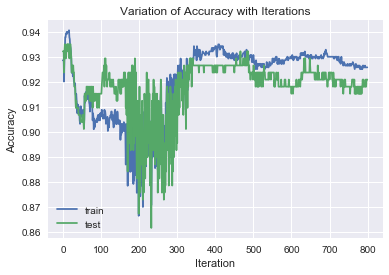

In [26]:
#boosting
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

AdaBoost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                           n_estimators=800,learning_rate=0.05)
AdaBoost_model=AdaBoost.fit(X_train,y_train)

#Plot Iteration based score
train_scores = list(AdaBoost.staged_score(X_train,y_train))
test_scores = list(AdaBoost.staged_score(X_test, y_test))

plt.plot(train_scores,label='train')
plt.plot(test_scores,label='test')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title("Variation of Accuracy with Iterations")
plt.legend()

print(AdaBoost.score(X_train, y_train))
print(AdaBoost.score(X_test, y_test))

In [27]:
#LDA & QDA
lda = LinearDiscriminantAnalysis(store_covariance=True)#, priors=[1,1,1])
qda = QuadraticDiscriminantAnalysis(store_covariance=True)#, priors=[1,1,1])
lda_model=lda.fit(X_train, y_train)
qda_model=qda.fit(X_train, y_train)

In [31]:
## comparasion of accuracy of different model
classifiers=[random_forest_model, ovr_model, poly_model, best_tree_model, AdaBoost_model,lda_model, qda_model]
names = ['random forest','logistic (simple)', 'logistic (polynomial)', 'decision tree', 'boosting' ,'lda','qda']
accuracy_table=pd.DataFrame()
j=0
for i in classifiers:
    accuracy_table.loc[names[j],r'$ accuracy(train)$']=np.mean(cross_val_score(i, X_train, y_train, cv=5))
    y_pred_test = i.predict(X_test)
    accuracy_table.loc[names[j],r'$ accuracy(test)$']=accuracy_score(y_test, y_pred_test)
    j=j+1

accuracy_table

,$ accuracy(train)$,$ accuracy(test)$
random forest,0.924384,0.926554
logistic (simple),0.576679,0.579096
logistic (polynomial),0.578809,0.562147
decision tree,0.926489,0.932203
boosting,0.884068,0.920904
lda,0.859338,0.858757
qda,0.863586,0.872881
